Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools

In [4]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column, "New_cases", "Cumulative_cases"]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

In [5]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(
    df, n_future, n_past, train_test_split_percentage, validation_split_percentage
):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past : i, 0:n_feature])
        y_data.append(df[i + n_future - 1 : i + n_future, 0])

    split_training_test_starting_point = int(
        round(train_test_split_percentage * len(x_data))
    )
    split_train_validation_starting_point = int(
        round(split_training_test_starting_point * (1 - validation_split_percentage))
    )

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]
    y_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return (
        np.array(x_train),
        np.array(x_test),
        np.array(x_val),
        np.array(y_train),
        np.array(y_test),
        np.array(y_val),
    )

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(1420, 3)

In [7]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=30,
    train_test_split_percentage=0.9,
    validation_split_percentage=0,
)

In [8]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1251, 30, 3)
(139, 30, 3)
(1251, 1)
(139, 1)


In [9]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(
    LSTM(
        units=16,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(
    optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1280      
                                                                 
 dropout (Dropout)           (None, 30, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3409 (13.32 KB)
Trainable params: 3409 (13.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(
    X_train, y_train, validation_split=0.3, epochs=200, batch_size=64, callbacks=[es]
)

Epoch 1/200


14/14 [==============================] - 2s 42ms/step - loss: 1.1828 - root_mean_squared_error: 1.0876 - val_loss: 0.5279 - val_root_mean_squared_error: 0.7266
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 0.6565 - root_mean_squared_error: 0.8103 - val_loss: 0.3956 - val_root_mean_squared_error: 0.6289
Epoch 3/200
14/14 [==============================] - 0s 12ms/step - loss: 0.4953 - root_mean_squared_error: 0.7038 - val_loss: 0.2835 - val_root_mean_squared_error: 0.5324
Epoch 4/200
14/14 [==============================] - 0s 13ms/step - loss: 0.4543 - root_mean_squared_error: 0.6741 - val_loss: 0.2163 - val_root_mean_squared_error: 0.4651
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 0.4254 - root_mean_squared_error: 0.6522 - val_loss: 0.1670 - val_root_mean_squared_error: 0.4086
Epoch 6/200
14/14 [==============================] - 0s 13ms/step - loss: 0.4161 - root_mean_squared_error: 0.6451 - val_loss: 0.1367 - val_root_mean_sq

In [11]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

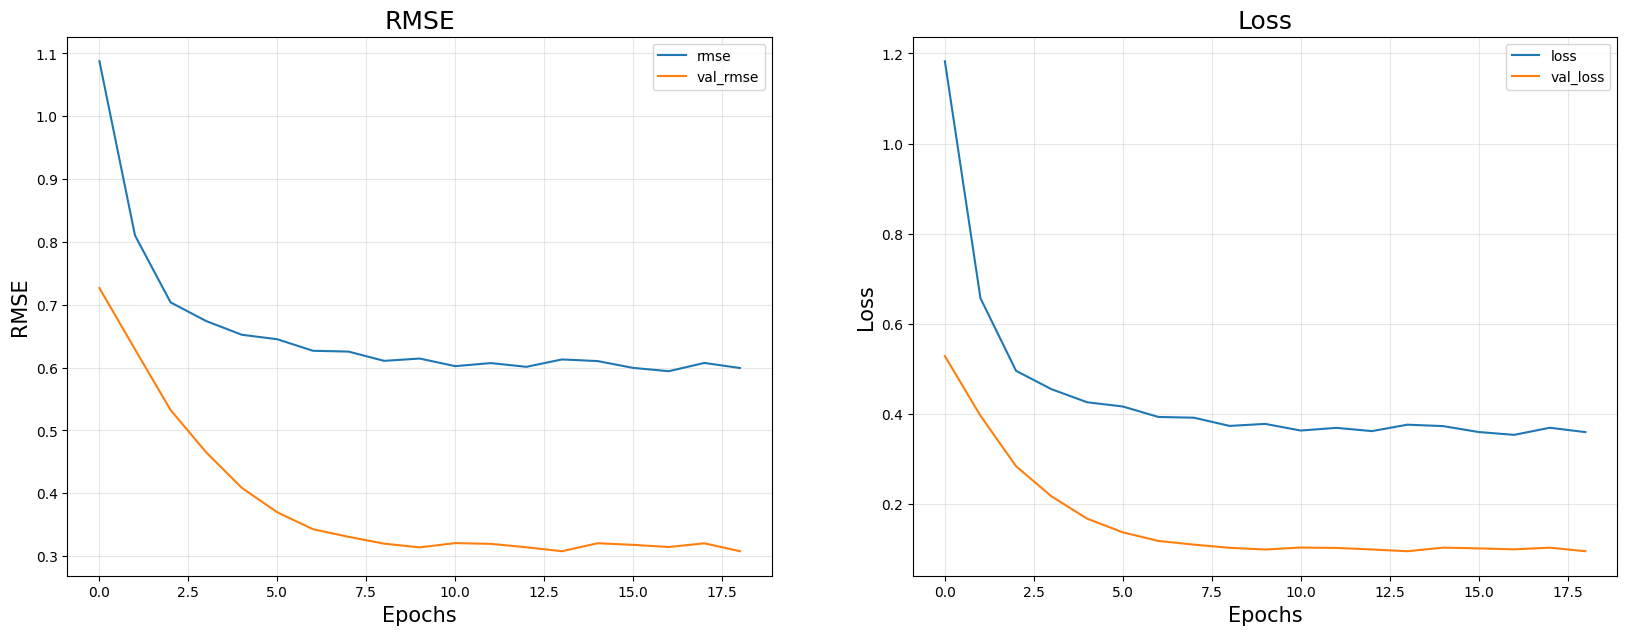

In [12]:
fig = plt.figure(figsize=(20, 7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history["root_mean_squared_error"], label="rmse")
plt.plot(
    history.epoch, history.history["val_root_mean_squared_error"], label="val_rmse"
)

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


# Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [13]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

5/5 [==============================] - 0s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384
test loss, test acc: [0.0192 0.1384]


In [14]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        # with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
        """''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        """ ""

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        """''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        """ ""

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )

        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [15]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [7, 28,365],
    [0.2],
]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)  # change x_train shape

[(True, True, True, 64, 7, 0.2), (True, True, True, 64, 28, 0.2), (True, True, True, 64, 365, 0.2), (True, True, True, 128, 7, 0.2), (True, True, True, 128, 28, 0.2), (True, True, True, 128, 365, 0.2), (True, True, True, 256, 7, 0.2), (True, True, True, 256, 28, 0.2), (True, True, True, 256, 365, 0.2), (True, True, False, 64, 7, 0.2), (True, True, False, 64, 28, 0.2), (True, True, False, 64, 365, 0.2), (True, True, False, 128, 7, 0.2), (True, True, False, 128, 28, 0.2), (True, True, False, 128, 365, 0.2), (True, True, False, 256, 7, 0.2), (True, True, False, 256, 28, 0.2), (True, True, False, 256, 365, 0.2), (True, False, True, 64, 7, 0.2), (True, False, True, 64, 28, 0.2), (True, False, True, 64, 365, 0.2), (True, False, True, 128, 7, 0.2), (True, False, True, 128, 28, 0.2), (True, False, True, 128, 365, 0.2), (True, False, True, 256, 7, 0.2), (True, False, True, 256, 28, 0.2), (True, False, True, 256, 365, 0.2), (True, False, False, 64, 7, 0.2), (True, False, False, 64, 28, 0.2), (Tr

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.14887

Epoch 3: val_loss improved from 0.14887 to 0.08455, saving model to best_model.h5

Epoch 4: val_loss improved from 0.08455 to 0.08251, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.08251

Epoch 6: val_loss did not improve from 0.08251

Epoch 7: val_loss did not improve from 0.08251

Epoch 8: val_loss did not improve from 0.08251

Epoch 9: val_loss did not improve from 0.08251
Epoch 9: early stopping
0-th combination = (True, True, True, 64, 7, 0.2) 
 train accuracy: [0.28595665097236633, 0.5347491502761841] and test accuracy: [0.054470255970954895, 0.23338863253593445]
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.09394, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.09394

Epoch 3: val_loss improved from 0.09394 to 0.09307, saving model to best_model.h5

Epoch 4: val_loss improved from 0.09307 to 0.08753

In [16]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
21,True,False,True,128,7,0.2,"[0.20063577592372894, 0.44792383909225464]","[0.004339824430644512, 0.06587734073400497]"
24,True,False,True,256,7,0.2,"[0.1542966365814209, 0.39280611276626587]","[0.004807140212506056, 0.06933354586362839]"
56,False,False,True,64,365,0.2,"[0.26612430810928345, 0.5158723592758179]","[0.004817359149456024, 0.06940719485282898]"
59,False,False,True,128,365,0.2,"[0.26544997096061707, 0.5152183771133423]","[0.004843367729336023, 0.06959430873394012]"
5,True,True,True,128,365,0.2,"[0.2719452679157257, 0.5214837193489075]","[0.004934459924697876, 0.07024571299552917]"
...,...,...,...,...,...,...,...,...
70,False,False,False,256,28,0.2,"[0.2293928563594818, 0.47894975543022156]","[0.0931536853313446, 0.3052108883857727]"
19,True,False,True,64,28,0.2,"[0.37717825174331665, 0.6141483783721924]","[0.09971624612808228, 0.31577879190444946]"
42,False,True,True,256,7,0.2,"[0.21316806972026825, 0.46170127391815186]","[0.12640412151813507, 0.35553357005119324]"
39,False,True,True,128,7,0.2,"[0.2671944797039032, 0.516908586025238]","[0.14569415152072906, 0.3816990256309509]"


In [17]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)
print("**************************")
print(f"Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n")
print(f"Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n")
print(
    f"{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement"
)

Best Combination: 
 first_additional_layer = True
 second_additional_layer = False
 third_additional_layer = True
 n_neurons = 128
 n_batch_size = 7
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.1384

Results After Tunning:
 Test Set RMSE: 0.0659

52.0% Improvement


In [18]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = list(hist.iloc[0, :-2])

In [19]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.08342, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.08342

Epoch 3: val_loss did not improve from 0.08342

Epoch 4: val_loss did not improve from 0.08342

Epoch 5: val_loss did not improve from 0.08342

Epoch 6: val_loss did not improve from 0.08342
Epoch 6: early stopping


In [20]:
regressor.evaluate(X_test, y_test)

1/5 [=====>........................] - ETA: 0s - loss: 0.0605

5/5 [==============================] - 0s 15ms/step - loss: 0.0596


0.059593118727207184

In [21]:
y_pred = regressor.predict(X_test)

5/5 [==============================] - 1s 11ms/step


5/5 [==============================] - 0s 11ms/step


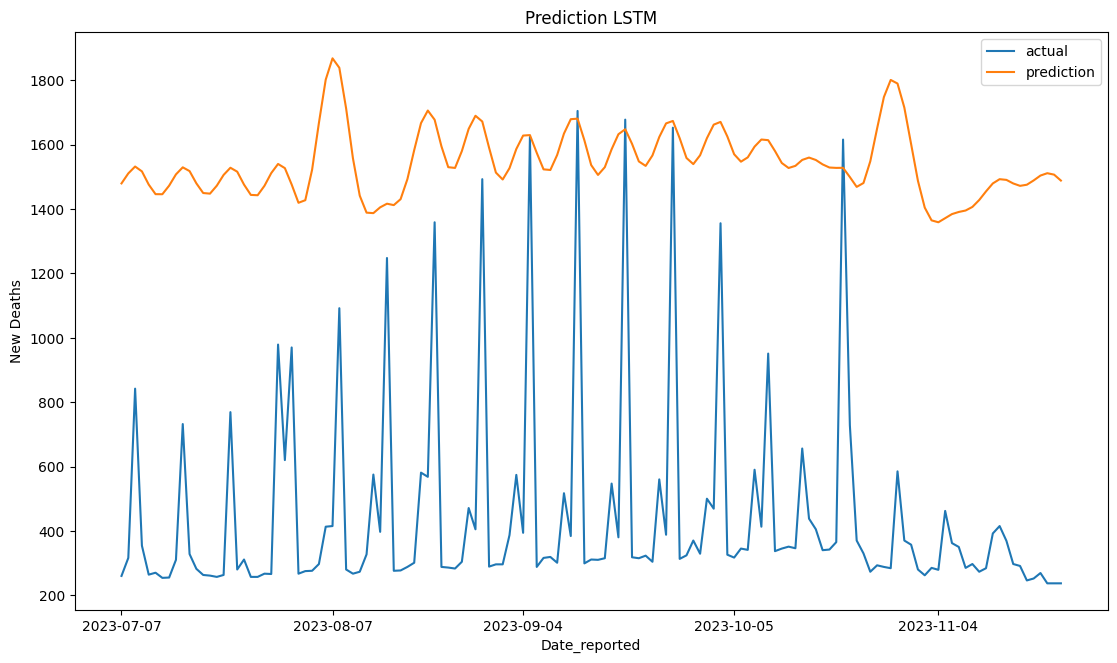

In [24]:
scaler = StandardScaler()
scaler.fit(df[[target_column]])
y_pred = regressor.predict(X_test)
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]

import matplotlib.dates as mdates
data_length = len(unscaled_y_test)

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[-data_length:], unscaled_y_test, label="actual")
ax.plot(dates[-data_length:], unscaled_y_pred, label="prediction")
ax.set_title("Prediction LSTM")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [25]:
from metrics import print_evaluation_metrics
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test)


Evaluation Metrics:
MSE: 1294258.73
RMSE: 1137.65
MAE: 1097.23
MAPE: 332.87
SMAPE: 116.18
